In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 38.5 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 880 kB 57.7 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=59177477fba55a651916bceeb06c62d4949a8074b827ce13c653d019ef29479c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import transformers
from transformers import TFAutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [3]:
try:
   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
   print('Running on TPU ', tpu.master())
except ValueError:
   tpu = None
 
if tpu:
   tf.config.experimental_connect_to_cluster(tpu)
   tf.tpu.experimental.initialize_tpu_system(tpu)
   strategy = tf.distribute.TPUStrategy(tpu)
else:
   strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.3.175.2:8470


In [4]:
train = pd.read_csv("/content/drive/MyDrive/deep-learning-project/tweets.csv")

In [5]:
# dropping id, location, keyword column
train.drop(['id','location','keyword'],axis=1,inplace=True)

**Cleaning Data**

In [6]:
#The tweets may contain urls, numbers, etc which are not useful to us in our model development. The clean-text package allows an easy removal of such items.
!pip install clean-text[gpl]
 
from cleantext import clean

     |████████████████████████████████| 175 kB 5.4 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 235 kB 49.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=659823a1e29a488f7a89856d447d233a483d9ee4e2b303b50b1207ded31d4896
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [7]:
#The clean function has various parameters that help in cleaning the given text in one go
def text_cleaning(text):
   text=clean(text,
     fix_unicode=True,               # fix various unicode errors
     to_ascii=True,                 # transliterate to closest ASCII representation
     lower=True,                    # lowercase text
     no_line_breaks=True,           # fully strip line breaks
     no_urls=True,                  # replace all URLs with ''
     no_emails=True,                # replace all email addresses with ''
     no_phone_numbers=True,         # replace all phone numbers with ''
     no_numbers=True,               # replace all numbers with ''
     no_digits=True,                # replace all digits with ''
     no_currency_symbols=True,      # replace all currency symbols with ''
     no_punct=True,                 # fully remove punctuation
     replace_with_url="",
     replace_with_email="",
     replace_with_phone_number="",
     replace_with_number="",
     replace_with_digit="",
     replace_with_currency_symbol="",
     lang="en"                      # set to 'en' for English
   )
   return text

In [8]:
for i in range(len(train)):
   train['text'].iloc[i]=text_cleaning(train['text'].iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
#Removing Stop Words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stoplist = stopwords.words('english')

In [11]:
for i in range(len(train)):
  train['text'].iloc[i] = [word for word in train['text'].iloc[i].split() if word not in stoplist]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
print(train['text'])

0        [communal, violence, bhainsa, telangana, stone...
1        [telangana, section, imposed, bhainsa, january...
2               [arsonist, sets, cars, ablaze, dealership]
3               [arsonist, sets, cars, ablaze, dealership]
4        [lord, jesus, love, brings, freedom, pardon, f...
                               ...                        
11365    [media, warned, us, well, advance, wrecked, wh...
11366    [feel, directly, attacked, 💀, consider, moonbi...
11367    [feel, directly, attacked, 💀, consider, moonbi...
11368    [ok, remember, outcast, nd, dora, au, au, wrec...
11369            [jake, corway, wrecked, running, th, irp]
Name: text, Length: 11370, dtype: object


In [13]:
# empty list for holding words from each row of train['text']
#distribution of the most common words found in the tweets
text_combined=[]

In [14]:
for i in range(len(train)):
 text_combined.append(train['text'].iloc[i])

In [15]:
from itertools import chain
flatten_list_text = list(chain.from_iterable(text_combined))

In [16]:
import collections
word_counters = collections.Counter(flatten_list_text)

In [17]:
words_with_counts = pd.DataFrame(word_counters.most_common(15),columns=['words', 'count'])

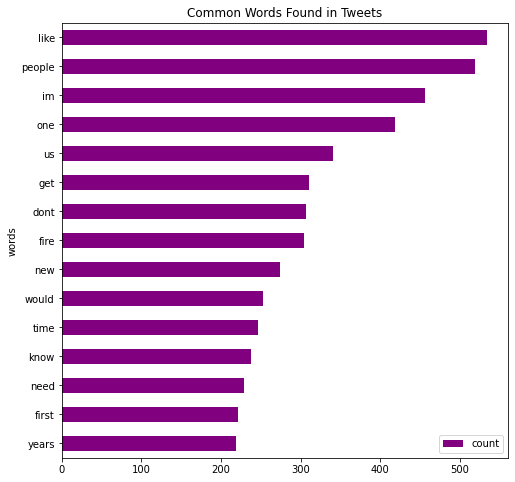

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
 
# Plot horizontal bar graph
# plot the frequency distribution after sorting
words_with_counts.sort_values(by='count').plot.barh(x='words', y='count',ax=ax,color="purple")
 
ax.set_title("Common Words Found in Tweets")
 
plt.show()

**Modeling and Training**

**We will write our neural network model where the first layer will be the pre-trained BERT model followed by our own network layers.**

In [19]:
def build_model(transformer, max_len=512):
   input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
   sequence_output = transformer(input_word_ids)[0]
   cls_token = sequence_output[:, 0, :]
   x = tf.keras.layers.Dropout(0.35)(cls_token)
 
   # make output dense layer
   out = Dense(1, activation='sigmoid')(x)
  
   model = Model(inputs=input_word_ids, outputs=out)
   model.compile(Adam(lr=3e-5), loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC()])
  
   return model

**We use the bert-based-uncased pretrained model and pass it our above written build_model function for constructing our model**

In [20]:
with strategy.scope():
   transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
   model = build_model(transformer_layer, max_len=512)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, sel

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

**Data Preprocessing**

In [22]:
#We first tokenize all our input datasets by using the BERT pre-trained tokenizer.
import transformers
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [23]:
#Saving the loaded tokenizer to my local environment
save_path = 'distilbert_base_uncased/'
if not os.path.exists(save_path):
   os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

('distilbert_base_uncased/tokenizer_config.json',
 'distilbert_base_uncased/special_tokens_map.json',
 'distilbert_base_uncased/vocab.txt',
 'distilbert_base_uncased/added_tokens.json')

In [24]:
#Reload the dataset
from tokenizers import BertWordPieceTokenizer
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

**We will be using fast_tokenizer to encode our input.The fast_encode encodes the text to numbers so that it can be used for model training**

In [25]:
def fast_encode(texts, tokenizer, size=256, maxlen=512):
   tokenizer.enable_truncation(max_length=maxlen)  # truncate the text and limit it to maxlen
   tokenizer.enable_padding(length=maxlen)         # pad sentences shorter than maxlen
   ids_full = []
  
   for i in tqdm(range(0, len(texts), size)):
       text = texts[i:i+size].tolist()
       encs = tokenizer.encode_batch(text)        
       ids_full.extend([enc.ids for enc in encs])
  
   return np.array(ids_full)

In [26]:
x = fast_encode(train.text.astype(str), fast_tokenizer, maxlen=512)

  0%|          | 0/45 [00:00<?, ?it/s]

**Preparing Datasets**

In [27]:
#Creating Batches of Data
tf.data.Dataset
BATCH_SIZE=64
y=train['target'].values

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.1, random_state=42)

In [29]:
#Creating Training Dataset
train_dataset = (
   tf.data.Dataset
     .from_tensor_slices((X_train, y_train))
     .repeat()
     .shuffle(2048)
     .batch(BATCH_SIZE)
   .prefetch(tf.data.experimental.AUTOTUNE)
)

In [30]:
#Creating Test Dataset
test_data = (
   tf.data.Dataset
   .from_tensor_slices(X_test)
   .batch(BATCH_SIZE)
)

**Model Training**

In [31]:
#We train the model by calling its fit method. The strategy decides on the distribution strategy on the TPU cluster during training.
with strategy.scope():
   train_history = model.fit(
     train_dataset,
     steps_per_epoch=150,
     epochs = 10
   )

Epoch 1/10
150/150 [==============================] - 125s 254ms/step - loss: 0.4939 - auc: 0.5292
Epoch 2/10
150/150 [==============================] - 38s 254ms/step - loss: 0.3242 - auc: 0.8697
Epoch 3/10
150/150 [==============================] - 38s 254ms/step - loss: 0.2254 - auc: 0.9376
Epoch 4/10
150/150 [==============================] - 38s 254ms/step - loss: 0.1628 - auc: 0.9677
Epoch 5/10
150/150 [==============================] - 38s 254ms/step - loss: 0.1028 - auc: 0.9856
Epoch 6/10
150/150 [==============================] - 38s 254ms/step - loss: 0.0732 - auc: 0.9915
Epoch 7/10
150/150 [==============================] - 38s 256ms/step - loss: 0.0521 - auc: 0.9939
Epoch 8/10
150/150 [==============================] - 38s 254ms/step - loss: 0.0441 - auc: 0.9956
Epoch 9/10
150/150 [==============================] - 38s 254ms/step - loss: 0.0269 - auc: 0.9972
Epoch 10/10
150/150 [==============================] - 38s 254ms/step - loss: 0.0277 - auc: 0.9978


**Inference on Test Data**

In [32]:
#Inference on Test Data
predictions = model.predict(X_test)

In [33]:
#We flatten the predictions from 2-dim to a 1-dimensional array
flattened_predictions = list(chain.from_iterable(predictions))

In [34]:
for i in range(len(flattened_predictions)):
 if flattened_predictions[i] <= 0.5:
   flattened_predictions[i] = 0
 else:
   flattened_predictions[i] = 1

In [35]:
#First Five Predictions
flattened_predictions[:5]

[0, 0, 1, 0, 1]

In [36]:
#Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, flattened_predictions)

0.9182058047493403

**LIVE TWEET ANALYSIS**

In [37]:
import re
import tweepy
from tweepy import OAuthHandler
from cleantext import clean

In [38]:
# convert tweet into tokens.
#Accepts a tweet text as input and tokenizes its contents using the specified tokenizer.   
def convert_lines(tweet, max_seq_length,tokenizer):
 max_seq_length -=2
 all_tokens = []
 
 tokens_a = tokenizer.tokenize(tweet)
 if len(tokens_a)>max_seq_length:
   tokens_a = tokens_a[:max_seq_length]
 
 # remove stopwords
 from nltk.corpus import stopwords
 import nltk
 stoplist = stopwords.words('english')
 tokens_b = [word for word in tokens_a if not word in stoplist]
 
 one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_b+["[SEP]"])+[0] * (max_seq_length - len(tokens_b))
 all_tokens.append(one_token)
 
 return np.array(all_tokens)


In [39]:
# Function for predicting the contents of a given tweet
def predict_disaster(tweet):
      
 maxlen = 512
 
 tweet2 = text_cleaning(tweet)
 
 token_input2 = convert_lines(tweet2,maxlen,tokenizer)
 
 seg_input2 = np.zeros((token_input2.shape[0],maxlen))
 mask_input2 = np.ones((token_input2.shape[0],maxlen))
 
 hehe = model.predict(token_input2,verbose=1,batch_size=32)
 
 if hehe <= 0.5:
   return 'no disaster'
 else:
   return 'real disaster'

In [40]:
!pip install snscrape

In [41]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [54]:
#Loading Live Tweets
query = "(crime) lang:en"
tweets = []
limit = 200


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    
    # print(vars(tweet[0]))
     #break
     if len(tweets) == limit:
        break
     else:
       if tweet.content not in tweets:
            tweets.append(tweet.content)
    

In [43]:
import itertools
pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper('query:(crime) lang:en','geolocation: India, 1000km').get_items(), 10))


,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss
0,https://twitter.com/QueryAlways/status/1522388...,2022-05-06 01:30:29+00:00,I don't know Statute of Limitations for falsif...,1522388296474968064,QueryAlways,[https://twitter.com/QueryAlways/status/152238...,https://twitter.com/QueryAlways/status/1522387...,[https://t.co/gQb1lY7LWf],https://t.co/gQb1lY7LWf
1,https://twitter.com/SINCnational/status/152224...,2022-05-05 15:43:57+00:00,COMING SOON!!!\n\nFind out how to write a quer...,1522240691107254277,SINCnational,[http://www.sistersincrime.org/webinars],http://www.sistersincrime.org/webinars,[https://t.co/x5Fbn4qsyd],https://t.co/x5Fbn4qsyd
2,https://twitter.com/vishaldardevkd/status/1522...,2022-05-05 13:55:15+00:00,@makemytripcare When i asked you it is your se...,1522213335415939074,vishaldardevkd,[],,[],
3,https://twitter.com/QueryAlways/status/1522182...,2022-05-05 11:54:14+00:00,#AmberHeardIsALiar #AmberHeardIsAnAbuser Amber...,1522182880222674944,QueryAlways,[https://twitter.com/jamesydraws/status/152211...,https://twitter.com/jamesydraws/status/1522116...,[https://t.co/qYUUcxKouJ],https://t.co/qYUUcxKouJ
4,https://twitter.com/lebed_60/status/1522180790...,2022-05-05 11:45:55+00:00,Ministry. Now it is even more dangerous becaus...,1522180790561513472,lebed_60,[],,[],
5,https://twitter.com/CrimeQuestions/status/1522...,2022-05-05 10:28:07+00:00,@JHBWater 403681485 Hi. Days ago I filed a que...,1522161208975056896,CrimeQuestions,[],,[],
6,https://twitter.com/LAAHelpTeam/status/1522131...,2022-05-05 08:30:07+00:00,We are online today between 9:30am until 3:00p...,1522131514938597378,LAAHelpTeam,[],,[],
7,https://twitter.com/medronheira/status/1522107...,2022-05-05 06:54:32+00:00,https://t.co/RkM6zFI3Ek\nMy query is about USA...,1522107460768743425,medronheira,[https://en.m.wikipedia.org/wiki/Category:1988...,https://en.m.wikipedia.org/wiki/Category:1988_...,[https://t.co/RkM6zFI3Ek],https://t.co/RkM6zFI3Ek
8,https://twitter.com/PIBMumbai/status/152207294...,2022-05-05 04:37:23+00:00,How safe is it to share personal info online?\...,1522072944180342786,PIBMumbai,[http://youtu.be/1WLvMDSkArM],http://youtu.be/1WLvMDSkArM,[https://t.co/JQRpL8rWSN],https://t.co/JQRpL8rWSN
9,https://twitter.com/kiplugo1/status/1521963155...,2022-05-04 21:21:07+00:00,@EnaCoach kindly let the guys on your mbita of...,1521963155437596675,kiplugo1,[],,[],


In [55]:
print(tweets)

["@ela1949 2 inbred pieces of vermin, hope that once captured they receive unimaginably painful justice for their crimes.\n\nWhy Israel does not mass deport large numbers of these animals I just don't understand, along with wiping off the map the entire hamas leadership supporting these acts.", '@RedGlar9 @MJB24681 @TetraQammon @SouthTownKing @Bigteethyouhave @drdeblk @LifeNyc2 @ThePatriotPar15 @Synyster63 @428Panda @RoyU812 @TrumpLOST5 @_Project1000 @MattDelier @DonaldJsTrumps @BadgerinFlorida @BigBluHeart67 @BrandonPutin @RealDoctorT @huskygal19 @BsSlayah @UseLogicPlease1 @BDonedat @LibsAreSoDumb @theresamtequil1 @chriscr66024638 @michellmybell1 @McmastersMoose @egosempertecum1 @TragicEra @prynne_hyster @GrieveNSpin @emmanue00857463 @TomDoubting @SpongebobBirth @neville1776 @jefftheessene @LadyOfTheOcean1 @nevacomplyagain @CMcfunster @blondjewels @VeryDamagdGoods @Pittsburgbitch @Jetson77 @fvckbootlickers @IanIsNotMyName @AlphasGhost @FECKFECK611 @TheEndTimes__ @DennyGr28530407 “…the

In [56]:
final_tweets=[]
for tweet in tweets :
 
               # empty dictionary to store required params of a tweet
               parsed_tweet = {}
 
               # saving text of tweet
               parsed_tweet['text'] = tweet
              
               # saving sentiment of tweet
               parsed_tweet['class'] = predict_disaster(tweet)
                # appending parsed tweet to tweets list
                   # if tweet has retweets, ensure that it is appended only once
               if parsed_tweet not in final_tweets:
                  final_tweets.append(parsed_tweet)
      

1/1 [==============================] - 0s 457ms/step


In [57]:
real_d  = [tweet for tweet in final_tweets if tweet['class'] == 'real disaster'] 
print("Real Disaster tweets percentage: {} %".format(round((100*len(real_d )/len(final_tweets)),2)))
 
no_d = [tweet for tweet in final_tweets if tweet['class'] == 'no disaster']
print("No Disaster tweets percentage: {} %".format(round((100*len(no_d)/len(final_tweets)),2)))

Real Disaster tweets percentage: 2.5 %
No Disaster tweets percentage: 97.5 %


In [58]:
print("\n\n Real Disaster tweets:")
l=0
for tweet in real_d[:10]:
   l+=5
   print(tweet['text'])
   print('\n')
   if l==5:
     break



 Real Disaster tweets:
Delhi is increasingly reporting crimes inside/outside schools. Now, two 8-year-old girls have been molested inside their classroom by an unknown person at a Delhi school. The man removed the clothes of the girls, he then removed his clothes and urinated in front of the class.


@Angelo4justice3 I was one of the US officers in Iraq with the Intl investigations team. No WMD evidence of chemical weapons though. I have been going to Ukraine for some time over the years Ukrainians with family of Russian ethnicity were being targeted and gruesome crimes being committed. 😐


Two busy scenes on Alvarado Niles but appears that no crime has occurred.


The #SpecialTaskForce (STF) of #Odisha Crime Branch seized one #leopardskin from the possession of a wildlife criminal in Saintala area of Bolangir district on Thursday.
#odishanews #ommcomnews
https://t.co/D93YNbjsuE


Finished this and Im waiting for the police to show up in my door bc it looks like I committed a horribl

In [59]:
print("\n\n No Disaster tweets:")
l=0
for tweet in no_d[:10]:
   if l==5:
     break
   print(tweet['text'])
   l+=1
   print('\n')



 No Disaster tweets:
@ela1949 2 inbred pieces of vermin, hope that once captured they receive unimaginably painful justice for their crimes.

Why Israel does not mass deport large numbers of these animals I just don't understand, along with wiping off the map the entire hamas leadership supporting these acts.


@RedGlar9 @MJB24681 @TetraQammon @SouthTownKing @Bigteethyouhave @drdeblk @LifeNyc2 @ThePatriotPar15 @Synyster63 @428Panda @RoyU812 @TrumpLOST5 @_Project1000 @MattDelier @DonaldJsTrumps @BadgerinFlorida @BigBluHeart67 @BrandonPutin @RealDoctorT @huskygal19 @BsSlayah @UseLogicPlease1 @BDonedat @LibsAreSoDumb @theresamtequil1 @chriscr66024638 @michellmybell1 @McmastersMoose @egosempertecum1 @TragicEra @prynne_hyster @GrieveNSpin @emmanue00857463 @TomDoubting @SpongebobBirth @neville1776 @jefftheessene @LadyOfTheOcean1 @nevacomplyagain @CMcfunster @blondjewels @VeryDamagdGoods @Pittsburgbitch @Jetson77 @fvckbootlickers @IanIsNotMyName @AlphasGhost @FECKFECK611 @TheEndTimes__ @Den